Javier Alemán Rodríguez

# Cartpole con DeepQLearning

## Importación de librerías

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI BUS ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
import random
import gym
import numpy as np
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import TensorBoard
import time
import os
import webbrowser

## Establecimiento de parámetros

### Inicialización del entorno

In [11]:
env = gym.make('CartPole-v1', render_mode='human')

### Tamaño de estados y acciones

In [6]:
state_size = env.observation_space.shape[0]
state_size

4

In [7]:
action_size = env.action_space.n
action_size

2

### Tamaño de los lotes y episodios de entrenamientos

Se guardan los archivos de los pesos múltiplos de 50, al empezar en 0, el número de episodios debe ser un múltiplo de 50 + 1

In [6]:
batch_size = 32
n_episodes = 401

### Carpeta donde irá el modelo

In [7]:
output_dir = 'model_output/cartpole'

In [8]:
if not os.path.exists(output_dir):
  os.makedirs(output_dir)

### Callback de TensorBoard

In [9]:
tensorboard_callback = TensorBoard(log_dir='logs/', histogram_freq=1, write_graph=True)

## Clase agente

In [10]:
class DQNAgent:

	def __init__(self, state_size, action_size):
		self.state_size = state_size
		self.action_size = action_size

		self.memory = deque(maxlen=2000)

		self.gamma = 0.95

		self.epsilon = 1.0
		self.epsilon_decay = 0.995
		self.epsilon_min = 0.01

		self.learning_rate = 0.001

		self.model = self._build_model()

	def _build_model(self):

		model = Sequential()

		model.add(Dense(24, input_dim = self.state_size, activation='relu'))
		model.add(Dense(24, activation='relu'))
		model.add(Dense(self.action_size, activation='linear'))
		
		model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))

		return model
	
	def remember(self, state, action, reward, next_state, done):
		self.memory.append((state, action, reward, next_state, done))

	def act(self, state):
		if np.random.rand() <= self.epsilon:
			return random.randrange(self.action_size)
		act_values = self.model.predict(state)
		return np.argmax(act_values[0])

	def replay(self, batch_size):

		minibatch = random.sample(self.memory, batch_size)

		for state, action, reward, next_state, done in minibatch:
			target = reward
			if not done:
				target = (reward + self.gamma * np.amax(self.model.predict(next_state)[0]))
			target_f = self.model.predict(state)
			target_f[0][action] = target

			self.model.fit(state, target_f, epochs=1, verbose=0, callbacks=[tensorboard_callback])

		if self.epsilon > self.epsilon_min:
			self.epsilon *= self.epsilon_decay

	def load(self, name):
		self.model.load_weights(name)

	def save(self, name):
		self.model.save_weights(name)

### Instanciación del agente

In [11]:
agent = DQNAgent(state_size, action_size)

c:\Users\redbe\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Entrenamos el modelo

In [16]:
done = False

for e in range(n_episodes):
  
	state = env.reset()
	state = np.reshape(state[0], [1, state_size])

	for time in range(5000):

		action = agent.act(state)

		next_state, reward, done, _ , _ = env.step(action)

		reward = reward if not done else -10

		next_state = np.reshape(next_state, [1, state_size])

		agent.remember(state, action, reward, next_state, done)

		state = next_state

		if done:
			print("episode: {}/{}, score: {}, e: {:.2}".format(e, n_episodes, time, agent.epsilon))
			break

	if len(agent.memory) > batch_size:
		agent.replay(batch_size)

	if e % 50 == 0:
		agent.save(output_dir + '{:04d}.weights.h5'.format(e))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━

KeyboardInterrupt: 

### Guardamos el modelo

In [13]:
agent.model.save("model_output/cartpole/model_cart_pole.keras")

## Pruebas de ejecución

Podemos reiniciar la ejecución y continuar con el modelo y los pesos guardados

Establecemos el estado y tiempo

Utilizamos el modelo para predecir la acción

In [4]:
model = load_model("model_output/cartpole/model_cart_pole.keras")

In [12]:
import time

model.load_weights('model_output/cartpole0400.weights.h5')

state = env.reset()
state = np.reshape(state[0], [1, state_size])
time_t = 0

while True:
	env.render()
	action = np.argmax(model.predict(state)[0]) 
	next_state, reward, done, _ , _ = env.step(action)
	next_state = np.reshape(next_state, [1, state_size])
	state = next_state
	time_t += 1
	print(time_t)
	time.sleep(0.01)
	if done:
		break

print('Done')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
9
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
11
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
12
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
13
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
14
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
16
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
17
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
18
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
19
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
21
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
22
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
23
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 

Para cerrar la ventana del juego

In [13]:
env.close()

## Generación de gráficas con TensorBoard

Ahora vamos a lanzar TensorBoard para generar gráficas a partir de los logs

In [26]:
%load_ext tensorboard

Establecemos la ruta de los logs y el puerto en el que lo queremos abrir.

In [31]:
%tensorboard --logdir=logs/train/ --port=6008

Lo abrimos en el navegador

In [32]:
webbrowser.open('http://localhost:6008')

True

Nos apareceran los siguientes gráficos en la pestaña de histogramas

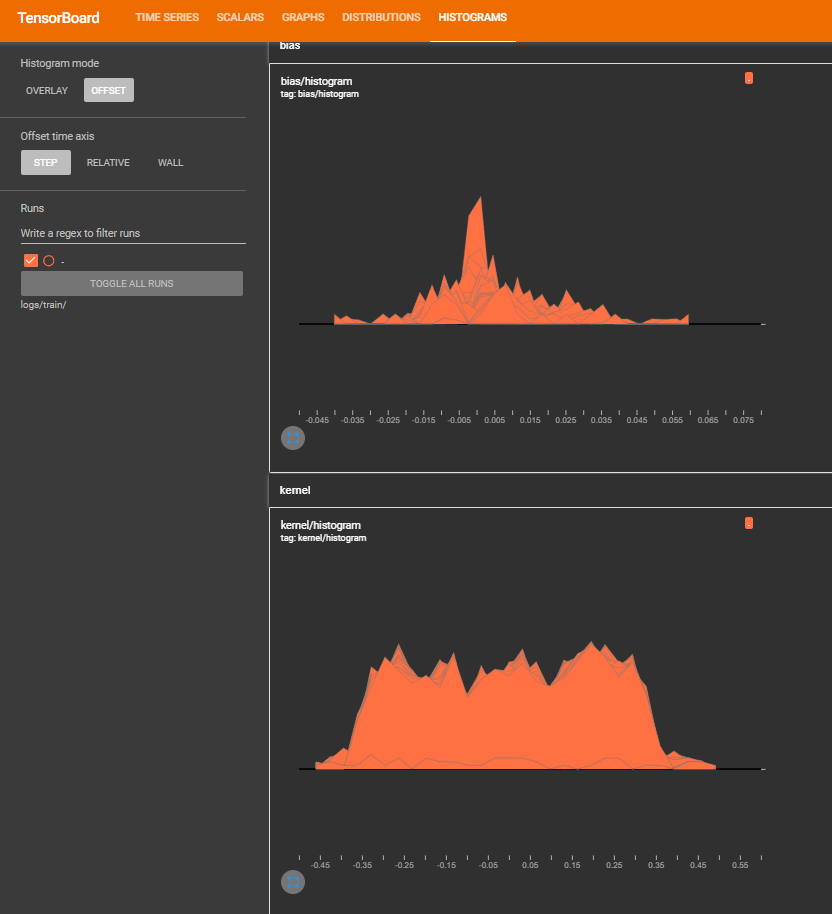